In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
bs = 64

In [4]:
path = Path('/home/william/data/human-protein-atlas-image-classification/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [7]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [8]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [9]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [10]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [11]:
test_fnames[:5]

[PosixPath('/home/william/data/human-protein-atlas-image-classification/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/william/data/human-protein-atlas-image-classification/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/william/data/human-protein-atlas-image-classification/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/william/data/human-protein-atlas-image-classification/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/william/data/human-protein-atlas-image-classification/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [12]:
src.add_test(test_fnames, label='0');

LabelLists;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: .
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/william/data/human-protein-atlas-image-classification;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: .
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/william/data/human-protein-atlas-image-classification;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: .
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512

In [13]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [14]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [15]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [16]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

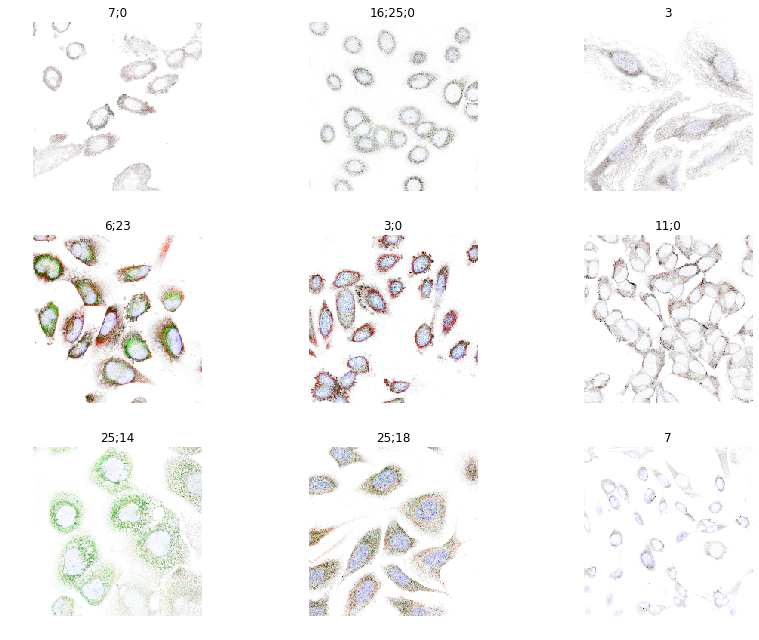

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [19]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [20]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [21]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


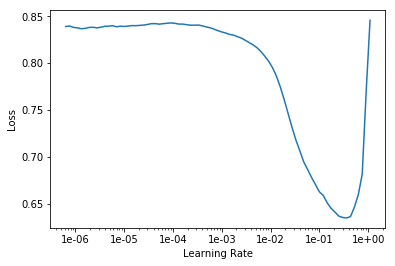

In [23]:
learn.recorder.plot()

In [24]:
lr = 3e-2

In [25]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:40
epoch  train_loss  valid_loss  fbeta   
1      0.135880    0.143851    0.496961  (02:09)
2      0.137360    0.139784    0.518900  (02:07)
3      0.125225    0.126279    0.582821  (02:07)
4      0.115448    0.126466    0.626896  (02:07)
5      0.105616    0.105299    0.644369  (02:08)



In [26]:
learn.save('stage-1-rn50-datablocks')

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


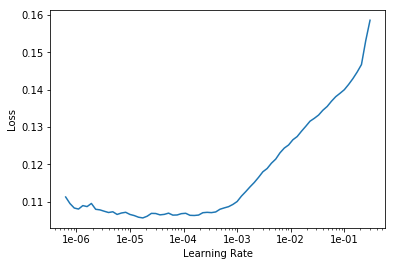

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

Total time: 39:10
epoch  train_loss  valid_loss  fbeta   
1      0.109667    0.155611    0.626423  (02:36)
2      0.110943    0.114875    0.623779  (02:36)
3      0.109368    0.150954    0.612238  (02:36)
4      0.108172    0.141205    0.587201  (02:36)
5      0.108150    0.130050    0.637721  (02:36)
6      0.102617    0.108451    0.619096  (02:36)
7      0.102491    0.187115    0.635789  (02:36)
8      0.100008    0.098371    0.661671  (02:36)
9      0.096139    0.099643    0.683945  (02:36)
10     0.093640    0.094433    0.678350  (02:36)
11     0.089169    0.090767    0.688339  (02:36)
12     0.087881    0.088234    0.697956  (02:36)
13     0.085696    0.091604    0.696905  (02:36)
14     0.083266    0.087665    0.695674  (02:36)
15     0.083326    0.086742    0.699768  (02:36)



In [31]:
learn.save('stage-2-rn50')

In [32]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)